# Cat and Dog classifier with CNN

In [2]:
# Import TF 2.x
# Run this cell if TensorFlow 2.x isn't the default in Colab
import tensorflow as tf
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
  print(tf.__version__)
except Exception:
  print('Old tensorflow')

2.2.0


In [3]:
# Check the version and GPU
print('Tensorflow version: ', tf.__version__)
print('GPU', 'available (Okey)' if tf.config.list_physical_devices('GPU') else 'not available :(')

Tensorflow version:  2.2.0
GPU available (Okey)


In [1]:
# Download dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Unzip zipfile
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

--2020-06-29 14:12:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.5.240, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   135MB/s    in 0.5s    

2020-06-29 14:12:23 (135 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 16s - loss: 0.6924 - accuracy: 0.5240 - val_loss: 0.6779 - val_accuracy: 0.5840
Epoch 2/100
100/100 - 16s - loss: 0.6859 - accuracy: 0.5450 - val_loss: 0.6597 - val_accuracy: 0.5790
Epoch 3/100
100/100 - 16s - loss: 0.6724 - accuracy: 0.5690 - val_loss: 0.6713 - val_accuracy: 0.52

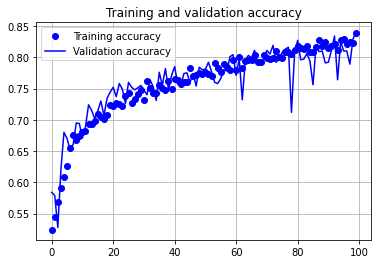

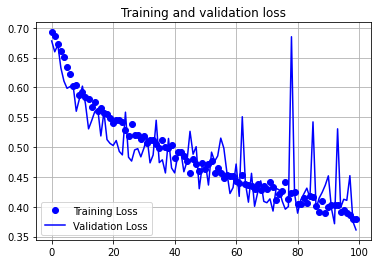

In [4]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.show()

In [6]:
# Save model to a HDF5 file
model.save('/tmp/model.h5')

In [8]:
# Testing on custom images
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = x / 255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0] > 0.5:
    print(fn + ' is a dog')
  else:
    print(fn + ' is a cat')

Saving cat-1.jpg to cat-1.jpg
Saving cat-2.jpg to cat-2.jpg
Saving cat-3.jpg to cat-3.jpg
Saving dog-1.jpg to dog-1.jpg
Saving dog-2.jpg to dog-2.jpg
Saving dog-3.jpg to dog-3.jpg
[0.27558848]
cat-1.jpg is a cat
[0.26279795]
cat-2.jpg is a cat
[0.09343454]
cat-3.jpg is a cat
[0.43388638]
dog-1.jpg is a cat
[0.9510957]
dog-2.jpg is a dog
[0.93795586]
dog-3.jpg is a dog
